In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import MDS
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from bokeh.io import curdoc, output_notebook
from bokeh.plotting import figure, show
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper, Slider, CustomJS
from bokeh.palettes import Spectral6
from bokeh.layouts import column, row

In [2]:
df = pd.read_csv('../../../examples/EFIplus_medit.zip',compression='zip', sep=";")

In [3]:
# copying df setup from Ex9

df.drop(df.iloc[:,5:15], axis=1, inplace=True)
df.rename(columns={'Sum of Run1_number_all':'Total_fish_individuals'}, inplace=True)
df.columns = list(map(str, df.columns))

envi_vars = ['Altitude', 'Actual_river_slope', 'Elevation_mean_catch', 'prec_ann_catch', 'temp_ann', 'temp_jan', 'temp_jul']

# added additional basements for the purpose of having more than 2 components
filt_basins = (df['Catchment_name'] == 'Douro') | (df['Catchment_name'] == 'Tejo') | (df['Catchment_name'] == 'Ebro') | (df['Catchment_name'] == 'Minho')
basins_df = df.loc[filt_basins, ['Catchment_name', *envi_vars]].dropna()
basins_df.reset_index(inplace=True)
basins_df.drop(columns='index', inplace=True)
basins_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2308 entries, 0 to 2307
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Catchment_name        2308 non-null   object 
 1   Altitude              2308 non-null   int64  
 2   Actual_river_slope    2308 non-null   float64
 3   Elevation_mean_catch  2308 non-null   float64
 4   prec_ann_catch        2308 non-null   float64
 5   temp_ann              2308 non-null   float64
 6   temp_jan              2308 non-null   float64
 7   temp_jul              2308 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 144.4+ KB


1. Run a Linear Discriminant Analysis based on quantitative environmental variables (see previous
exercises), using the Douro and Tejo basins as the pre-determined groups. Produce a biplot with
‘Catchment_name’ as a grouping variable.

In [4]:
basins_df

,Catchment_name,Altitude,Actual_river_slope,Elevation_mean_catch,prec_ann_catch,temp_ann,temp_jan,temp_jul
0,Tejo,1253,13.406,1603.519424,640.327779,9.3,0.6,18.9
1,Tejo,1155,9.398,1578.678579,633.238847,10.1,1.2,19.6
2,Tejo,1074,8.186,1553.219128,625.841858,10.1,1.2,19.5
3,Tejo,1018,11.736,1539.684999,622.111415,10.3,1.7,20.0
4,Tejo,979,2.670,1493.914010,608.146170,10.6,1.8,20.2
...,...,...,...,...,...,...,...,...
2303,Tejo,38,0.100,704.675069,515.039678,17.1,10.3,23.8
2304,Tejo,26,0.100,702.673201,516.097287,17.1,10.4,23.6
2305,Tejo,20,0.100,697.730192,518.386401,16.7,10.8,22.9
2306,Tejo,13,0.100,679.784324,556.028518,16.7,10.9,22.7


In [5]:
# scaling variables
basins_scaled = StandardScaler().fit_transform(basins_df.drop(columns='Catchment_name'))
scaled_basins_df = pd.DataFrame(data=basins_scaled, 
                                columns=basins_df.drop(columns='Catchment_name').columns)
scaled_basins_df['Catchment_name'] = basins_df['Catchment_name']
scaled_basins_df

,Altitude,Actual_river_slope,Elevation_mean_catch,prec_ann_catch,temp_ann,temp_jan,temp_jul,Catchment_name
0,1.987543,-0.053039,1.465014,-1.076008,-1.351397,-1.687853,-0.536840,Tejo
1,1.697500,-0.251226,1.407485,-1.102350,-1.000284,-1.450988,-0.254922,Tejo
2,1.457770,-0.311157,1.348522,-1.129837,-1.000284,-1.450988,-0.295196,Tejo
3,1.292030,-0.135617,1.317178,-1.143700,-0.912506,-1.253600,-0.093827,Tejo
4,1.176605,-0.583911,1.211176,-1.195595,-0.780839,-1.214123,-0.013279,Tejo
...,...,...,...,...,...,...,...,...
2303,-1.608405,-0.710992,-0.616644,-1.541578,2.071955,2.141469,1.436580,Tejo
2304,-1.643921,-0.710992,-0.621280,-1.537648,2.071955,2.180946,1.356032,Tejo
2305,-1.661679,-0.710992,-0.632728,-1.529142,1.896398,2.338857,1.074115,Tejo
2306,-1.682396,-0.710992,-0.674289,-1.389264,1.896398,2.378334,0.993568,Tejo


In [6]:
scaled_basins_df['Catchment_name'].value_counts()

Catchment_name
Ebro     713
Minho    707
Tejo     493
Douro    395
Name: count, dtype: int64

In [7]:
X = scaled_basins_df.drop(columns='Catchment_name')
y = scaled_basins_df['Catchment_name']

model = LDA(n_components=2)
lda = model.fit_transform(X, y)

In [8]:
lda_scores = pd.DataFrame(data = lda, 
                            columns = ['LD1', 'LD2'])
lda_scores.head(6)

,LD1,LD2
0,-1.253179,1.065325
1,-1.541251,1.299225
2,-0.637167,1.494571
3,-0.740531,1.065732
4,-0.693968,1.418719
5,-0.505759,1.559456


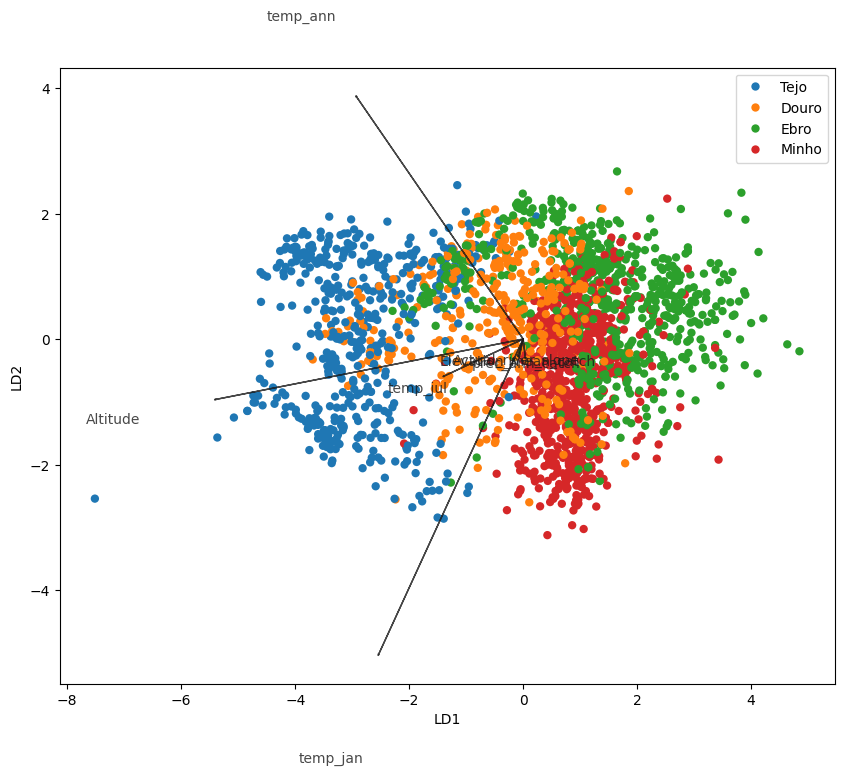

In [9]:
plt.figure(figsize=(10, 8))

sns.scatterplot(x=lda_scores['LD1'],
              y=lda_scores['LD2'],
              hue = scaled_basins_df['Catchment_name'].tolist(),
              linewidth=0,
              )

n = model.n_features_in_
for i in range(n):
        plt.arrow(0, 0, model.scalings_[i,0]*1.5, 
                  model.scalings_[i,1]*1.5,
                  color = (0.1, 0.1, 0.1, 0.8),
                  head_width=0.02) # plot arrows for each variable
        plt.text(model.scalings_[i,0]*2, # plot the names of the variables
                 model.scalings_[i,1]*2,
                 list(scaled_basins_df.columns)[i], 
                 color = (0.1, 0.1, 0.1, 0.8), 
                 ha = 'center', 
                 va = 'center') # variable labels for each arrow

plt.xlabel('LD1')
plt.ylabel('LD2')
plt.show()

2. Try to build interactive plots that display data in the space defined by the Discriminant Functions.

In [10]:
# load BokehJS - enables the plot to be displayed within the notebook
output_notebook()

Loading BokehJS ...

In [11]:
catch_list = y.unique().tolist()
color_mapper = CategoricalColorMapper(factors=catch_list, palette=Spectral6)

In [12]:
# July Temp vs Annual Temp

source = ColumnDataSource(data={
    'x': basins_df['temp_jan'],
    'y': basins_df['temp_ann'],
    'catchment': basins_df['Catchment_name']
})

In [13]:
# Save the minimum and maximum values of the gdp column: xmin, xmax
xmin, xmax = min(basins_df['temp_jan']), max(basins_df['temp_jan'])

# Save the minimum and maximum values of the co2 column: ymin, ymax
ymin, ymax = min(basins_df['temp_ann']), max(basins_df['temp_ann'])

In [14]:
# Create the figure: plot
plot = figure(title='Annual Temperature vs Temperature January', 
              height=600, width=1000,
              x_range=(xmin, xmax),
              y_range=(ymin, ymax), y_axis_type='log')

In [15]:
# Add circle glyphs to the plot
plot.scatter(x='x', y='y', fill_alpha=0.8, source=source, legend_field='catchment',
            color=dict(field='catchment', transform=color_mapper),
            size=7)

GlyphRenderer(id='p1046', ...)

In [16]:
# Produce interactive plot
# Set the legend.location attribute of the plot
plot.legend.location = 'bottom_right'

# Set the x-axis label
plot.xaxis.axis_label = 'January Temperature'

# Set the y-axis label
plot.yaxis.axis_label = 'Annual Temperature'

# Create a HoverTool - will allow the user to hover above a datapoint to see the name of the country, CO2 emissions nd GDP
hover = HoverTool(tooltips=[('Catchment', '@catchment'), ('January Temp', '@x'), ('Annual Temp', '@y')])

# Add the HoverTool to the plot
plot.add_tools(hover)
show(plot)

In [17]:
# Altitude vs July Temp

source = ColumnDataSource(data={
    'x': basins_df['Altitude'],
    'y': basins_df['temp_jul'],
    'catchment': basins_df['Catchment_name']
})

# Save the minimum and maximum values of the gdp column: xmin, xmax
xmin, xmax = min(basins_df['Altitude']), max(basins_df['Altitude'])

# Save the minimum and maximum values of the co2 column: ymin, ymax
ymin, ymax = min(basins_df['temp_jul']), max(basins_df['temp_jul'])

# Create the figure: plot
plot = figure(title='Altitude vs Temperature July', 
              height=600, width=1000,
              x_range=(xmin, xmax),
              y_range=(ymin, ymax), y_axis_type='log')

# Add circle glyphs to the plot
plot.scatter(x='x', y='y', fill_alpha=0.8, source=source, legend_field='catchment',
            color=dict(field='catchment', transform=color_mapper),
            size=7)

# Produce interactive plot
# Set the legend.location attribute of the plot
plot.legend.location = 'bottom_right'

# Set the x-axis label
plot.xaxis.axis_label = 'Altitude'

# Set the y-axis label
plot.yaxis.axis_label = 'Temperature July'

# Create a HoverTool - will allow the user to hover above a datapoint to see the name of the country, CO2 emissions nd GDP
hover = HoverTool(tooltips=[('Catchment', '@catchment'), ('Altitude', '@x'), ('July Temp', '@y')])

# Add the HoverTool to the plot
plot.add_tools(hover)
show(plot)

In [18]:
# LDA results

source = ColumnDataSource(data={
    'x': lda_scores['LD1'],
    'y': lda_scores['LD2'],
    'catchment': basins_df['Catchment_name']
})

# Save the minimum and maximum values of the gdp column: xmin, xmax
xmin, xmax = min(lda_scores['LD1']), max(lda_scores['LD1'])

# Save the minimum and maximum values of the co2 column: ymin, ymax
ymin, ymax = min(lda_scores['LD2']), max(lda_scores['LD2'])

# Create the figure: plot
plot = figure(title='LDA Results', 
              height=600, width=1000,
              x_range=(xmin, xmax),
              y_range=(ymin, ymax), y_axis_type='log')

# Add circle glyphs to the plot
plot.scatter(x='x', y='y', fill_alpha=0.8, source=source, legend_field='catchment',
            color=dict(field='catchment', transform=color_mapper),
            size=7)

# Produce interactive plot
# Set the legend.location attribute of the plot
plot.legend.location = 'bottom_right'

# Set the x-axis label
plot.xaxis.axis_label = 'LD1'

# Set the y-axis label
plot.yaxis.axis_label = 'LD2'

# Create a HoverTool - will allow the user to hover above a datapoint to see the name of the country, CO2 emissions nd GDP
hover = HoverTool(tooltips=[('Catchment', '@catchment'), ('LD1', '@x'), ('LD2', '@y')])

# Add the HoverTool to the plot
plot.add_tools(hover)
show(plot)